# Dimensionality reduction of scRNA-seq data
**Author**: Adam Klie (last modified: 10/08/2023)<br>
***
**Description**: This script performs multiple dimensionality reduction methods 

In [1]:
# Imports
import os
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import anndata2ri
import logging
from scipy.sparse import csr_matrix, issparse
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

by .GlobalEnv when processing object ‘.pbd_env’
/tmp/ipykernel_835464/1525380708.py:21: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
# Paths
input_h5ad_path = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_scRNA-seq/annotation/26Oct23/cellbender/H1-D11/normalize/sctransform_only.h5ad"
outdir_path = "TODO"

In [4]:
# If output directory does not exist, create it.
if not os.path.exists(outdir_path):
    os.makedirs(outdir_path)

In [3]:
# Read in h5ad
adata = sc.read_h5ad(input_h5ad_path)
adata

AnnData object with n_obs × n_vars = 8788 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'scrublet_doublet_score', 'scrublet_predicted_doublet', 'doublet_filter', 'pre_doublet_filter_leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'sctransform_genes'
    uns: 'scrublet'
    obsm: 'sctransform_scale_data'
    layers: 'counts'

In [36]:
# Define global run parameters
output_prefix = "6_dimensionality-reduction_scRNAseq"
gene_markers = ["INS", "TPH1", "GCG", "ZEB2", "SST"]


# Script 1: Chosen layer with chosen variable genes and scanpy functions

In [80]:
# Define run parameters for script
layer = "depth_normalization"
var_genes_column = "highly_variable"
scale = False
scale_max = 10
pca_n_comps = 50
n_neighbors = 30
umap_min_dist = 0.3
leiden_resolution = 0.5
random_state = 13

/tmp/ipykernel_3160978/108179098.py:13: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_pp.var["highly_variable"] = adata_pp.var[var_genes_column]
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


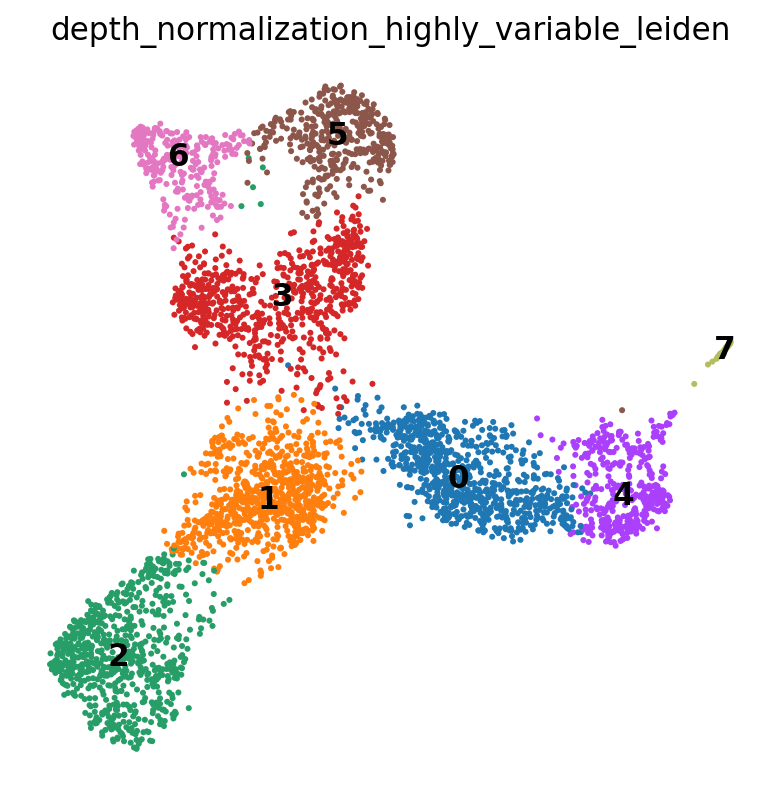

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


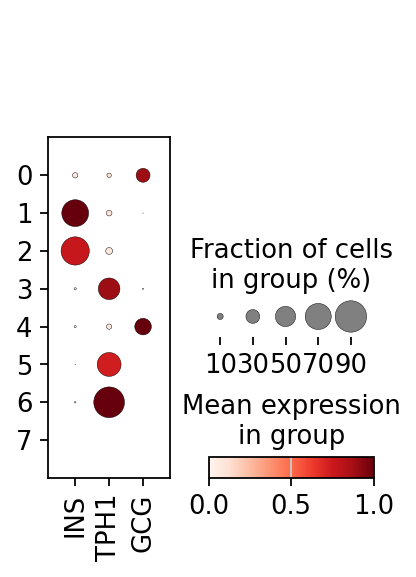

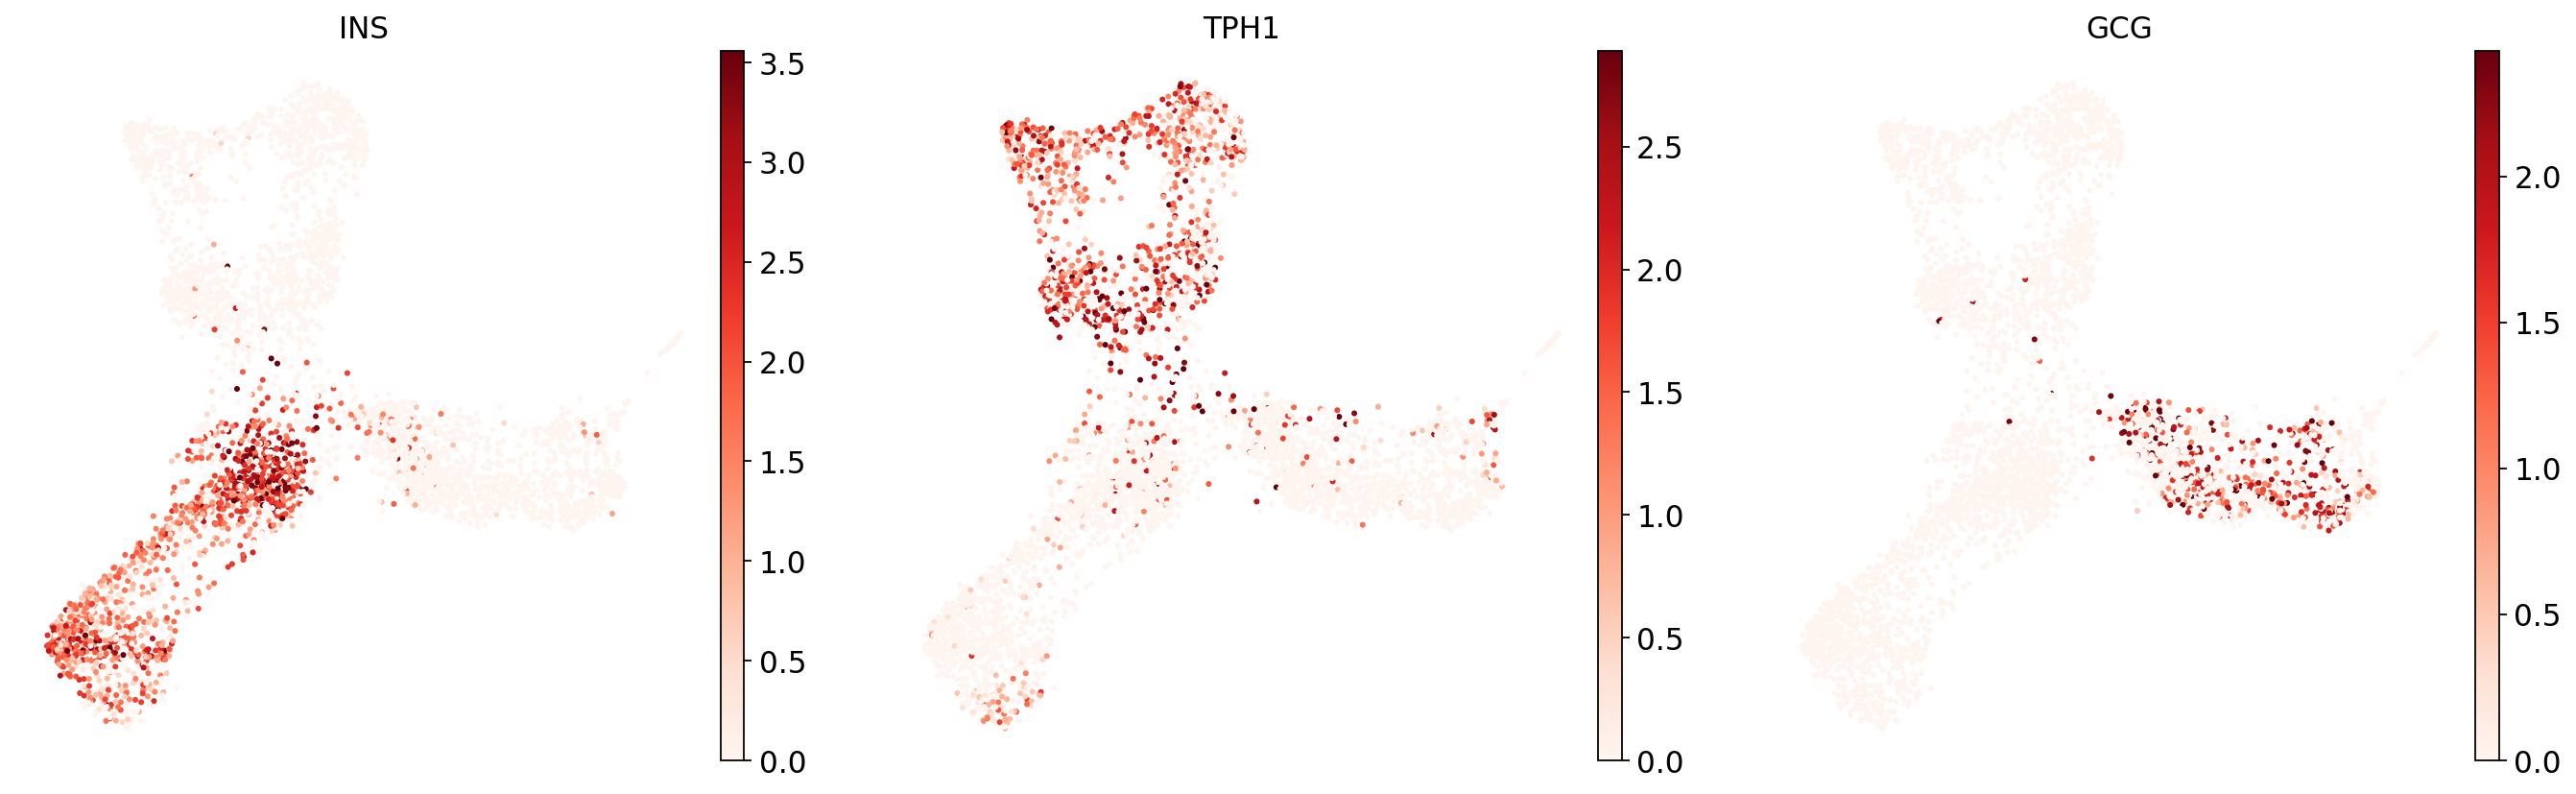

In [81]:
# Make a copy of the adata object
adata_pp = adata.copy()

# Choose a normalization
adata_pp.X = adata_pp.layers[layer]

# scale optionally
if scale:
    sc.pp.scale(adata_pp, max_value=scale_max)

# Highly variable genes
adata_pp = adata_pp[:, adata_pp.var[var_genes_column]]
adata_pp.var["highly_variable"] = adata_pp.var[var_genes_column]

# Run PCA
sc.tl.pca(adata_pp, n_comps=pca_n_comps, svd_solver="arpack", random_state=random_state, use_highly_variable=True, zero_center=True, dtype="float32", copy=False)

# Neighborhood graph
sc.pp.neighbors(adata_pp, use_rep="X_pca", n_neighbors=n_neighbors, random_state=random_state, n_pcs=pca_n_comps)

# UMAP
sc.tl.umap(adata_pp, min_dist=umap_min_dist, random_state=random_state)

# Clustering
sc.tl.leiden(adata_pp, resolution=leiden_resolution, random_state=random_state, key_added=f"{layer}_{var_genes_column}_leiden")

# Plot UMAP with leiden clusters
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.umap(adata_pp, color=[f"{layer}_{var_genes_column}_leiden"], legend_loc="on data", show=True)
    plt.savefig(os.path.join(outdir_path, f"{layer}_{var_genes_column}_umap_leiden.png"), dpi=300, bbox_inches="tight")
    plt.close()

# Plot SoupX markers as dotplot
gene_markers = [marker for marker in gene_markers if marker in adata_pp.var_names]
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.dotplot(
        adata_pp,
        groupby=f"{layer}_{var_genes_column}_leiden",
        var_names=gene_markers,
        standard_scale="var",
    )
    plt.savefig(os.path.join(outdir_path, f"{layer}_{var_genes_column}_umap_leiden_markers.png"), dpi=300, bbox_inches="tight")
    plt.close()

# Plot UMAP with markers
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.umap(
        adata_pp,
        color=gene_markers,
        vmin=0,
        vmax="p99", 
        sort_order=False, 
        frameon=False,
        cmap="Reds", 
    )
    plt.savefig(os.path.join(outdir_path, f"{layer}_{var_genes_column}_umap_markers.png"), dpi=300, bbox_inches="tight")
    plt.close()

# Save results in old adata object
adata.obsm[f"{layer}_{var_genes_column}_pca"] = adata_pp.obsm["X_pca"]
adata.obsm[f"{layer}_{var_genes_column}_umap"] = adata_pp.obsm["X_umap"]
adata.obs[f"{layer}_{var_genes_column}_leiden"] = adata_pp.obs[f"{layer}_{var_genes_column}_leiden"]

In [76]:
adata_pp.var[var_genes_column].value_counts()

True    4000
Name: highly_deviant, dtype: int64

In [77]:
# Check adata
adata

AnnData object with n_obs × n_vars = 4054 × 15708
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'at

# Script 2: An obsm dataframe and scanpy functions

In [48]:
# Define run parameters for script
obsm_key = "sctransform_scale_data"
pca_n_comps = 50
n_neighbors = 30
umap_min_dist = 0.3
leiden_resolution = 0.5
random_state = 13

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


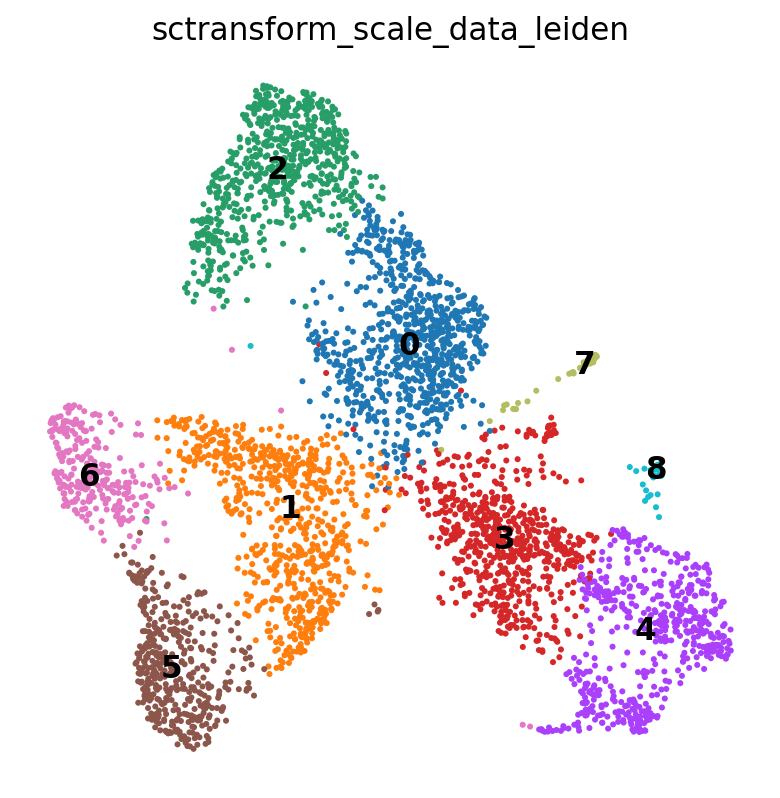

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


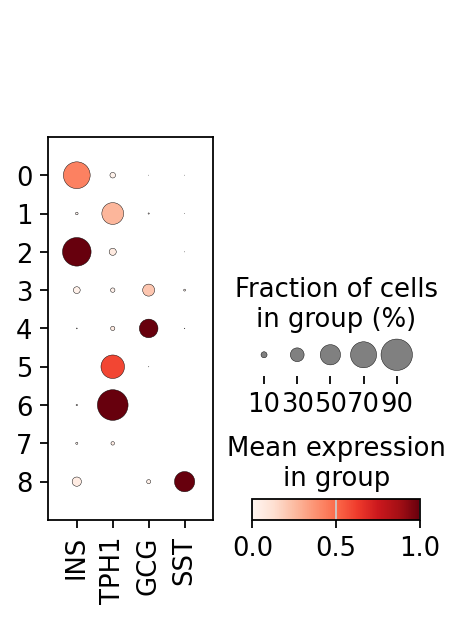

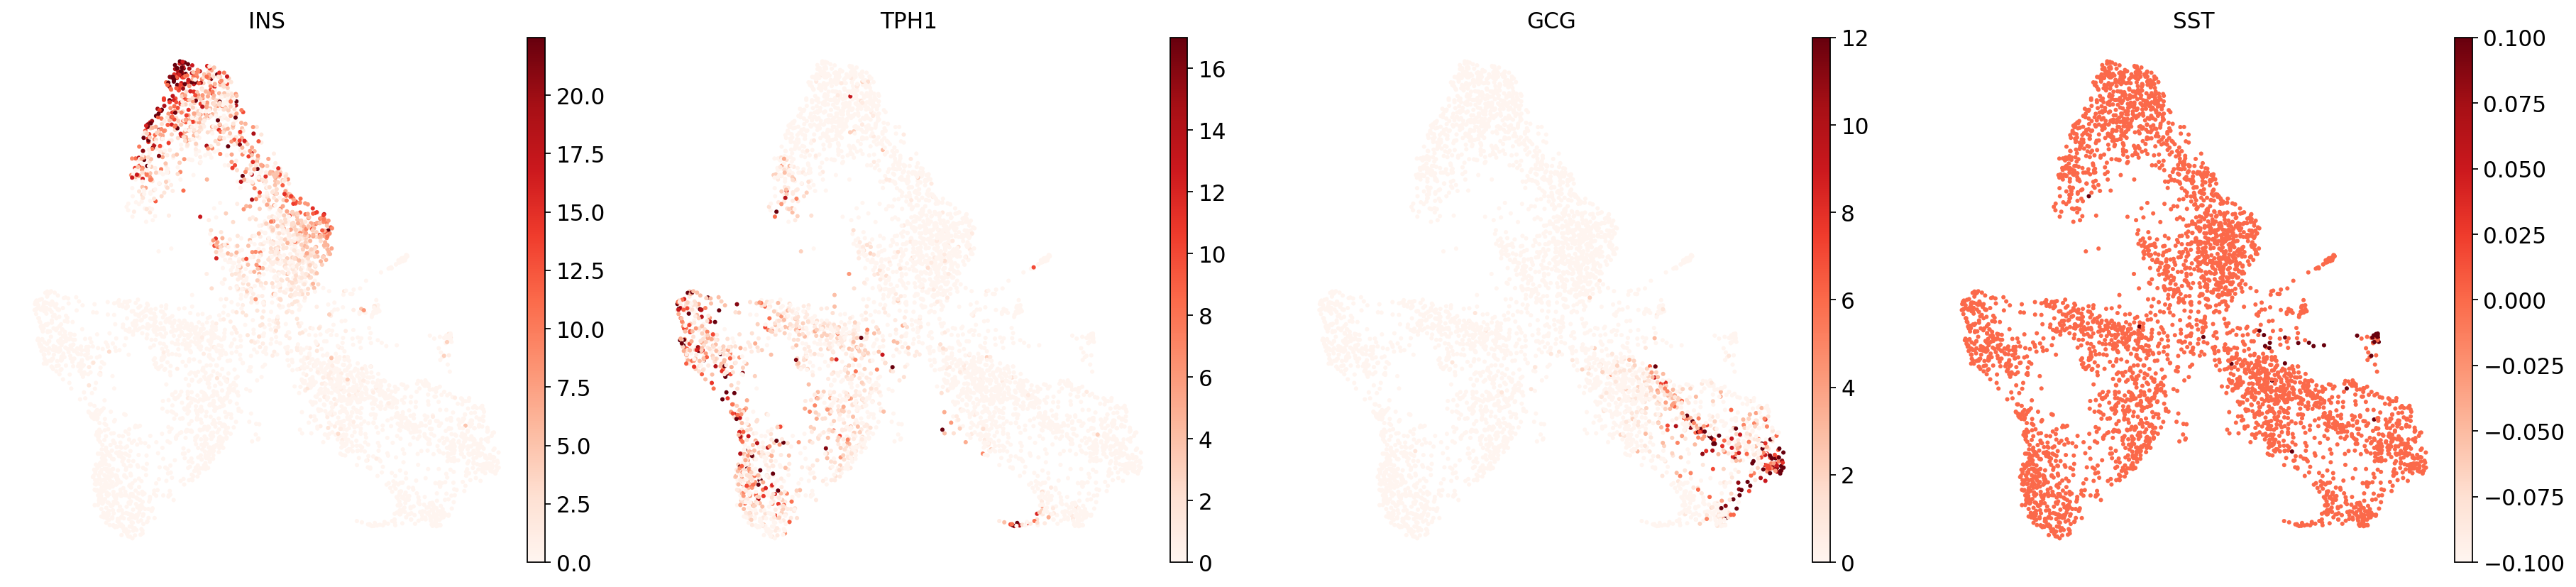

In [49]:
# Make a copy of the adata object
adata_pp = adata.copy()

# Peform PCA on SCTransform normalized data
adata_pp.obsm["X_pca"] = sc.pp.pca(adata_pp.obsm["sctransform_scale_data"].values, n_comps=pca_n_comps, use_highly_variable=False, return_info=False, random_state=random_state)

# Neighborhood graph
sc.pp.neighbors(adata_pp, use_rep="X_pca", n_neighbors=n_neighbors, random_state=random_state, n_pcs=pca_n_comps)

# UMAP
sc.tl.umap(adata_pp, min_dist=umap_min_dist, random_state=random_state)

# Clustering
sc.tl.leiden(adata_pp, resolution=leiden_resolution, random_state=random_state, key_added=f"{obsm_key}_leiden")

# Plot UMAP with leiden clusters
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.umap(adata_pp, color=[f"{obsm_key}_leiden"], legend_loc="on data", show=True)
    plt.savefig(os.path.join(outdir_path, f"{obsm_key}_umap_leiden.pdf"), dpi=300, bbox_inches="tight")
    plt.close()

# Plot SoupX markers as dotplot
gene_markers = [marker for marker in gene_markers if marker in adata_pp.var_names]
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.dotplot(
        adata_pp,
        groupby=f"{obsm_key}_leiden",
        var_names=gene_markers,
        standard_scale="var",
    )
    plt.savefig(os.path.join(outdir_path, f"{obsm_key}_umap_leiden_markers.pdf"), dpi=300, bbox_inches="tight")
    plt.close()

# Plot UMAP with markers
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.umap(
        adata_pp,
        color=gene_markers,
        vmin=0,
        vmax="p99", 
        sort_order=False, 
        frameon=False,
        cmap="Reds", 
    )
    plt.savefig(os.path.join(outdir_path, f"{obsm_key}_umap_markers.pdf"), dpi=300, bbox_inches="tight")
    plt.close()

# Save results in old adata object
adata.obsm[f"{obsm_key}_pca"] = adata_pp.obsm["X_pca"]
adata.obsm[f"{obsm_key}_umap"] = adata_pp.obsm["X_umap"]
adata.obs[f"{obsm_key}_leiden"] = adata_pp.obs[f"{obsm_key}_leiden"]

In [50]:
# Check adata
adata

AnnData object with n_obs × n_vars = 4054 × 15708
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'at

# Script 3: SCTransform with Seurat UMAP

In [60]:
# Define run parameters for script
counts_layer = "sctransform_corrected_counts"
data_layer = "sctransform_corrected_log1p_counts"
scale_data_layer = "sctransform_scale_data"
sctransform_var_genes_column = "sctransform_genes"
layer = "sctransform_seurat"
pca_n_comps = 50
n_neighbors = 30
leiden_resolution = 0.5
random_state = 13

In [52]:
%%R
library(Seurat)
library(SeuratObject)
library(Matrix)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [53]:
# Grab out of adata
counts_data = adata.layers[counts_layer].T.astype("float32")
data = adata.layers[data_layer].T.astype("float32")
scale_data_mat = adata.obsm[scale_data_layer].values.T.astype("float32")
cell_names = adata.obs_names
gene_names = adata.var_names
sct_gene_names = adata.var[adata.var[sctransform_var_genes_column]].index.values

In [59]:
# Toss into R's global environment
ro.globalenv["counts_data"] = counts_data
ro.globalenv["data"] = data
ro.globalenv["scale_data"] = scale_data_mat
ro.globalenv["cell_names"] = cell_names
ro.globalenv["gene_names"] = gene_names
ro.globalenv["sct_gene_names"] = sct_gene_names
ro.globalenv["random_state"] = random_state
ro.globalenv["pca_n_comps"] = pca_n_comps

In [55]:
%%R -o umap_rna -o pca_rna
set.seed(random_state)
counts_mtx = Matrix(counts_data, sparse = TRUE)
rownames(counts_mtx) = gene_names
colnames(counts_mtx) = cell_names
mtx = Matrix(data, sparse = TRUE)
rownames(mtx) = gene_names
colnames(mtx) = cell_names
rownames(scale_data) = sct_gene_names
colnames(scale_data) = cell_names
sobj = CreateSeuratObject(assay="SCT", counts=counts_mtx, data=mtx, min.cells=0, min.features=0)
sobj@assays$SCT@scale.data <- scale_data
VariableFeatures(sobj[["SCT"]]) <- sct_gene_names
sobj = RunPCA(sobj, verbose = FALSE)
sobj = RunUMAP(sobj, dims=1:pca_n_comps, reduction.name='umap.rna', reduction.key='rnaUMAP_')
pca_rna = Embeddings(sobj, reduction = "pca")
umap_rna = Embeddings(sobj, reduction = "umap.rna")

An object of class Seurat 
15708 features across 4054 samples within 1 assay 
Active assay: SCT (15708 features, 3000 variable features)


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


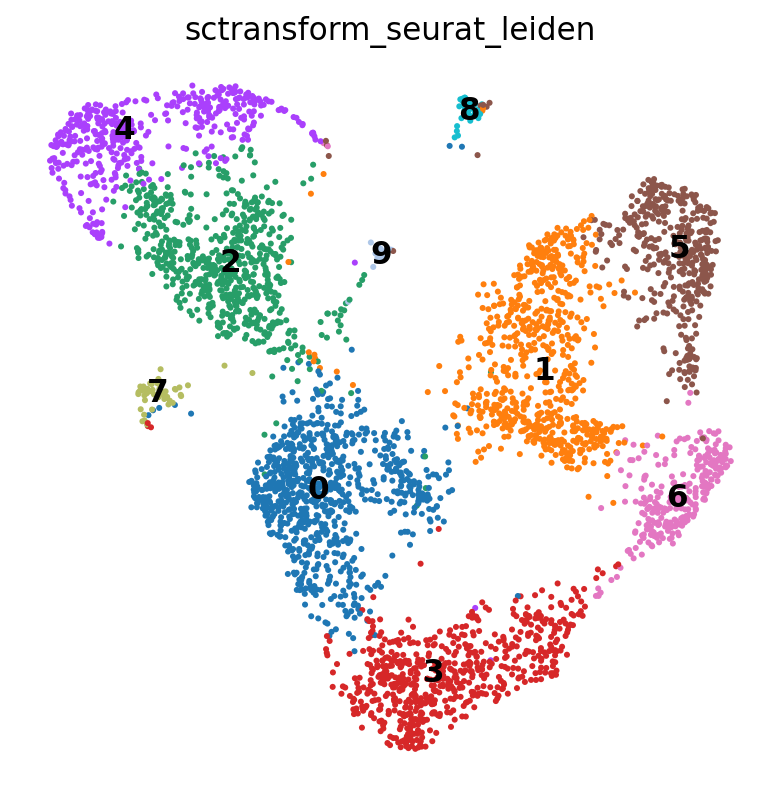

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


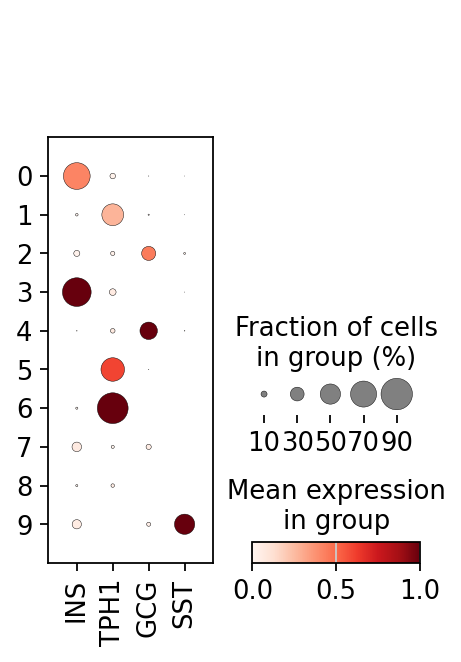

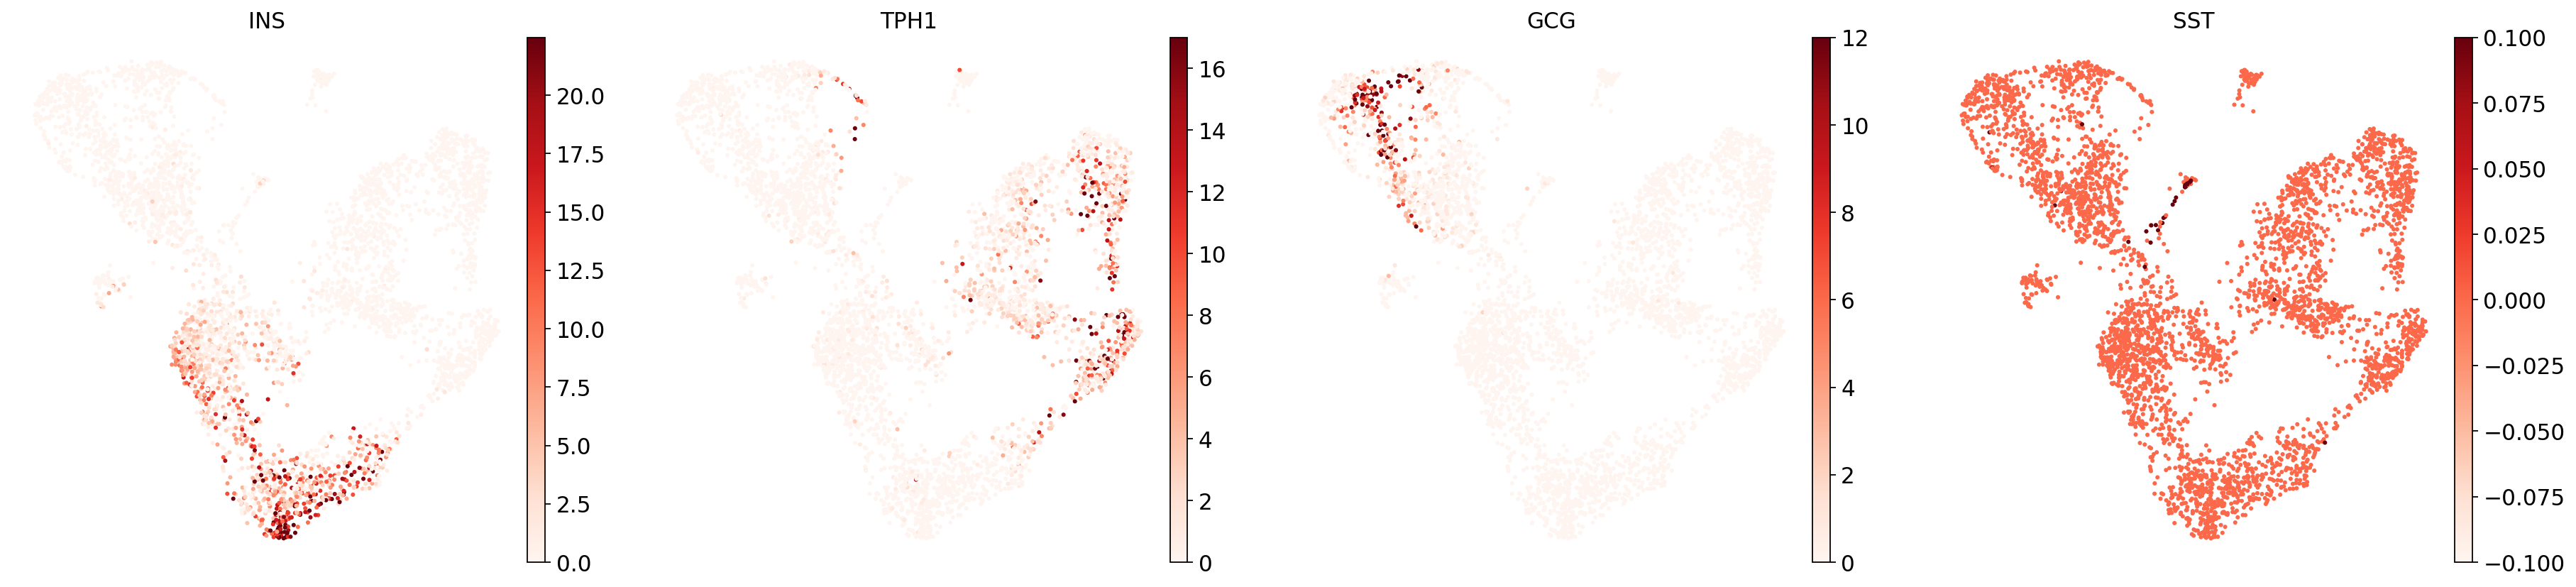

In [61]:
# Make a copy of the adata object
adata_pp = adata.copy()

# Add PCA and UMAP to adata
adata_pp.obsm["X_pca"] = pca_rna
adata_pp.obsm["X_umap"] = umap_rna

# Neighborhood graph
sc.pp.neighbors(adata_pp, use_rep="X_pca", n_neighbors=n_neighbors, random_state=random_state, n_pcs=pca_n_comps)

# Clustering
sc.tl.leiden(adata_pp, resolution=leiden_resolution, random_state=random_state, key_added=f"{layer}_leiden")

# Plot UMAP with leiden clusters
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.umap(adata_pp, color=[f"{layer}_leiden"], legend_loc="on data", show=True)
    plt.savefig(os.path.join(outdir_path, f"{layer}_umap_leiden.pdf"), dpi=300, bbox_inches="tight")
    plt.close()

# Plot SoupX markers as dotplot
gene_markers = [marker for marker in gene_markers if marker in adata_pp.var_names]
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.dotplot(
        adata_pp,
        groupby=f"{layer}_leiden",
        var_names=gene_markers,
        standard_scale="var",
    )
    plt.savefig(os.path.join(outdir_path, f"{layer}_umap_leiden_markers.pdf"), dpi=300, bbox_inches="tight")
    plt.close()

# Plot UMAP with markers
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.umap(
        adata_pp,
        color=gene_markers,
        vmin=0,
        vmax="p99", 
        sort_order=False, 
        frameon=False,
        cmap="Reds", 
    )
    plt.savefig(os.path.join(outdir_path, f"{layer}_umap_markers.pdf"), dpi=300, bbox_inches="tight")
    plt.close()

# Save results in old adata object
adata.obsm[f"{layer}_pca"] = adata_pp.obsm["X_pca"]
adata.obsm[f"{layer}_umap"] = adata_pp.obsm["X_umap"]
adata.obs[f"{layer}_leiden"] = adata_pp.obs[f"{layer}_leiden"]

# Script 4: GLM-PCA

In [27]:
%%R
library(scry)
library(SingleCellExperiment)

In [23]:
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
data_mat = adata.X.T[adata.var["highly_variable"]]
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat

In [28]:
%%R
sce = GLMPCA(SingleCellExperiment(list(counts=data_mat)), 2, assay="counts")

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AttributeError: 'DataFrame' object has no attribute 'shape'

In [ ]:
# Grab the 
pc_data = ro.r("cbind(as.data.frame(colData(sce2)), metadata(sce)$glmpca$factors")

# Save

In [86]:
cluster_cols = adata.obs.columns[adata.obs.columns.str.contains("leiden") | adata.obs.columns.str.contains("groups")]

In [89]:
adata.obs[cluster_cols].to_csv(os.path.join(outdir_path, f"initial_clustering_results.csv"))

In [ ]:
# Save the filtered data.
adata.write(os.path.join(outdir_path, "4_normalization_scRNAseq.h5ad"))

# DONE!

---

# Scratch

## Test script

```bash
input_h5ad_path=/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/09Oct23/dm32a/5_feature-selection_scRNAseq.h5ad
outdir_path=/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/09Oct23/dm32a

cd /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/bin/data_annotation/scanpy

cmd="python 6_dimensionality-reduction_scRNAseq.py \
--input_h5ad_path $input_h5ad_path \
--outdir_path $outdir_path \
sctransform_seurat \
--counts_layer sctransform_corrected_counts \
--data_layer sctransform_corrected_log1p_counts \
--scale_data_layer sctransform_scale_data \
--sctransform_var_genes_column sctransform_genes \
--layer sctransform_seurat"

echo $cmd
```

## Investigate clusterings

/tmp/ipykernel_3160978/3846121918.py:17: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (column1, data1) in enumerate(cluster_data.iteritems()):
/tmp/ipykernel_3160978/3846121918.py:18: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for j, (column2, data2) in enumerate(cluster_data.iteritems()):
/tmp/ipykernel_3160978/3846121918.py:18: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for j, (column2, data2) in enumerate(cluster_data.iteritems()):
/tmp/ipykernel_3160978/3846121918.py:18: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for j, (column2, data2) in enumerate(cluster_data.iteritems()):
/tmp/ipykernel_3160978/3846121918.py:18: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for j, (column2, data2) in en

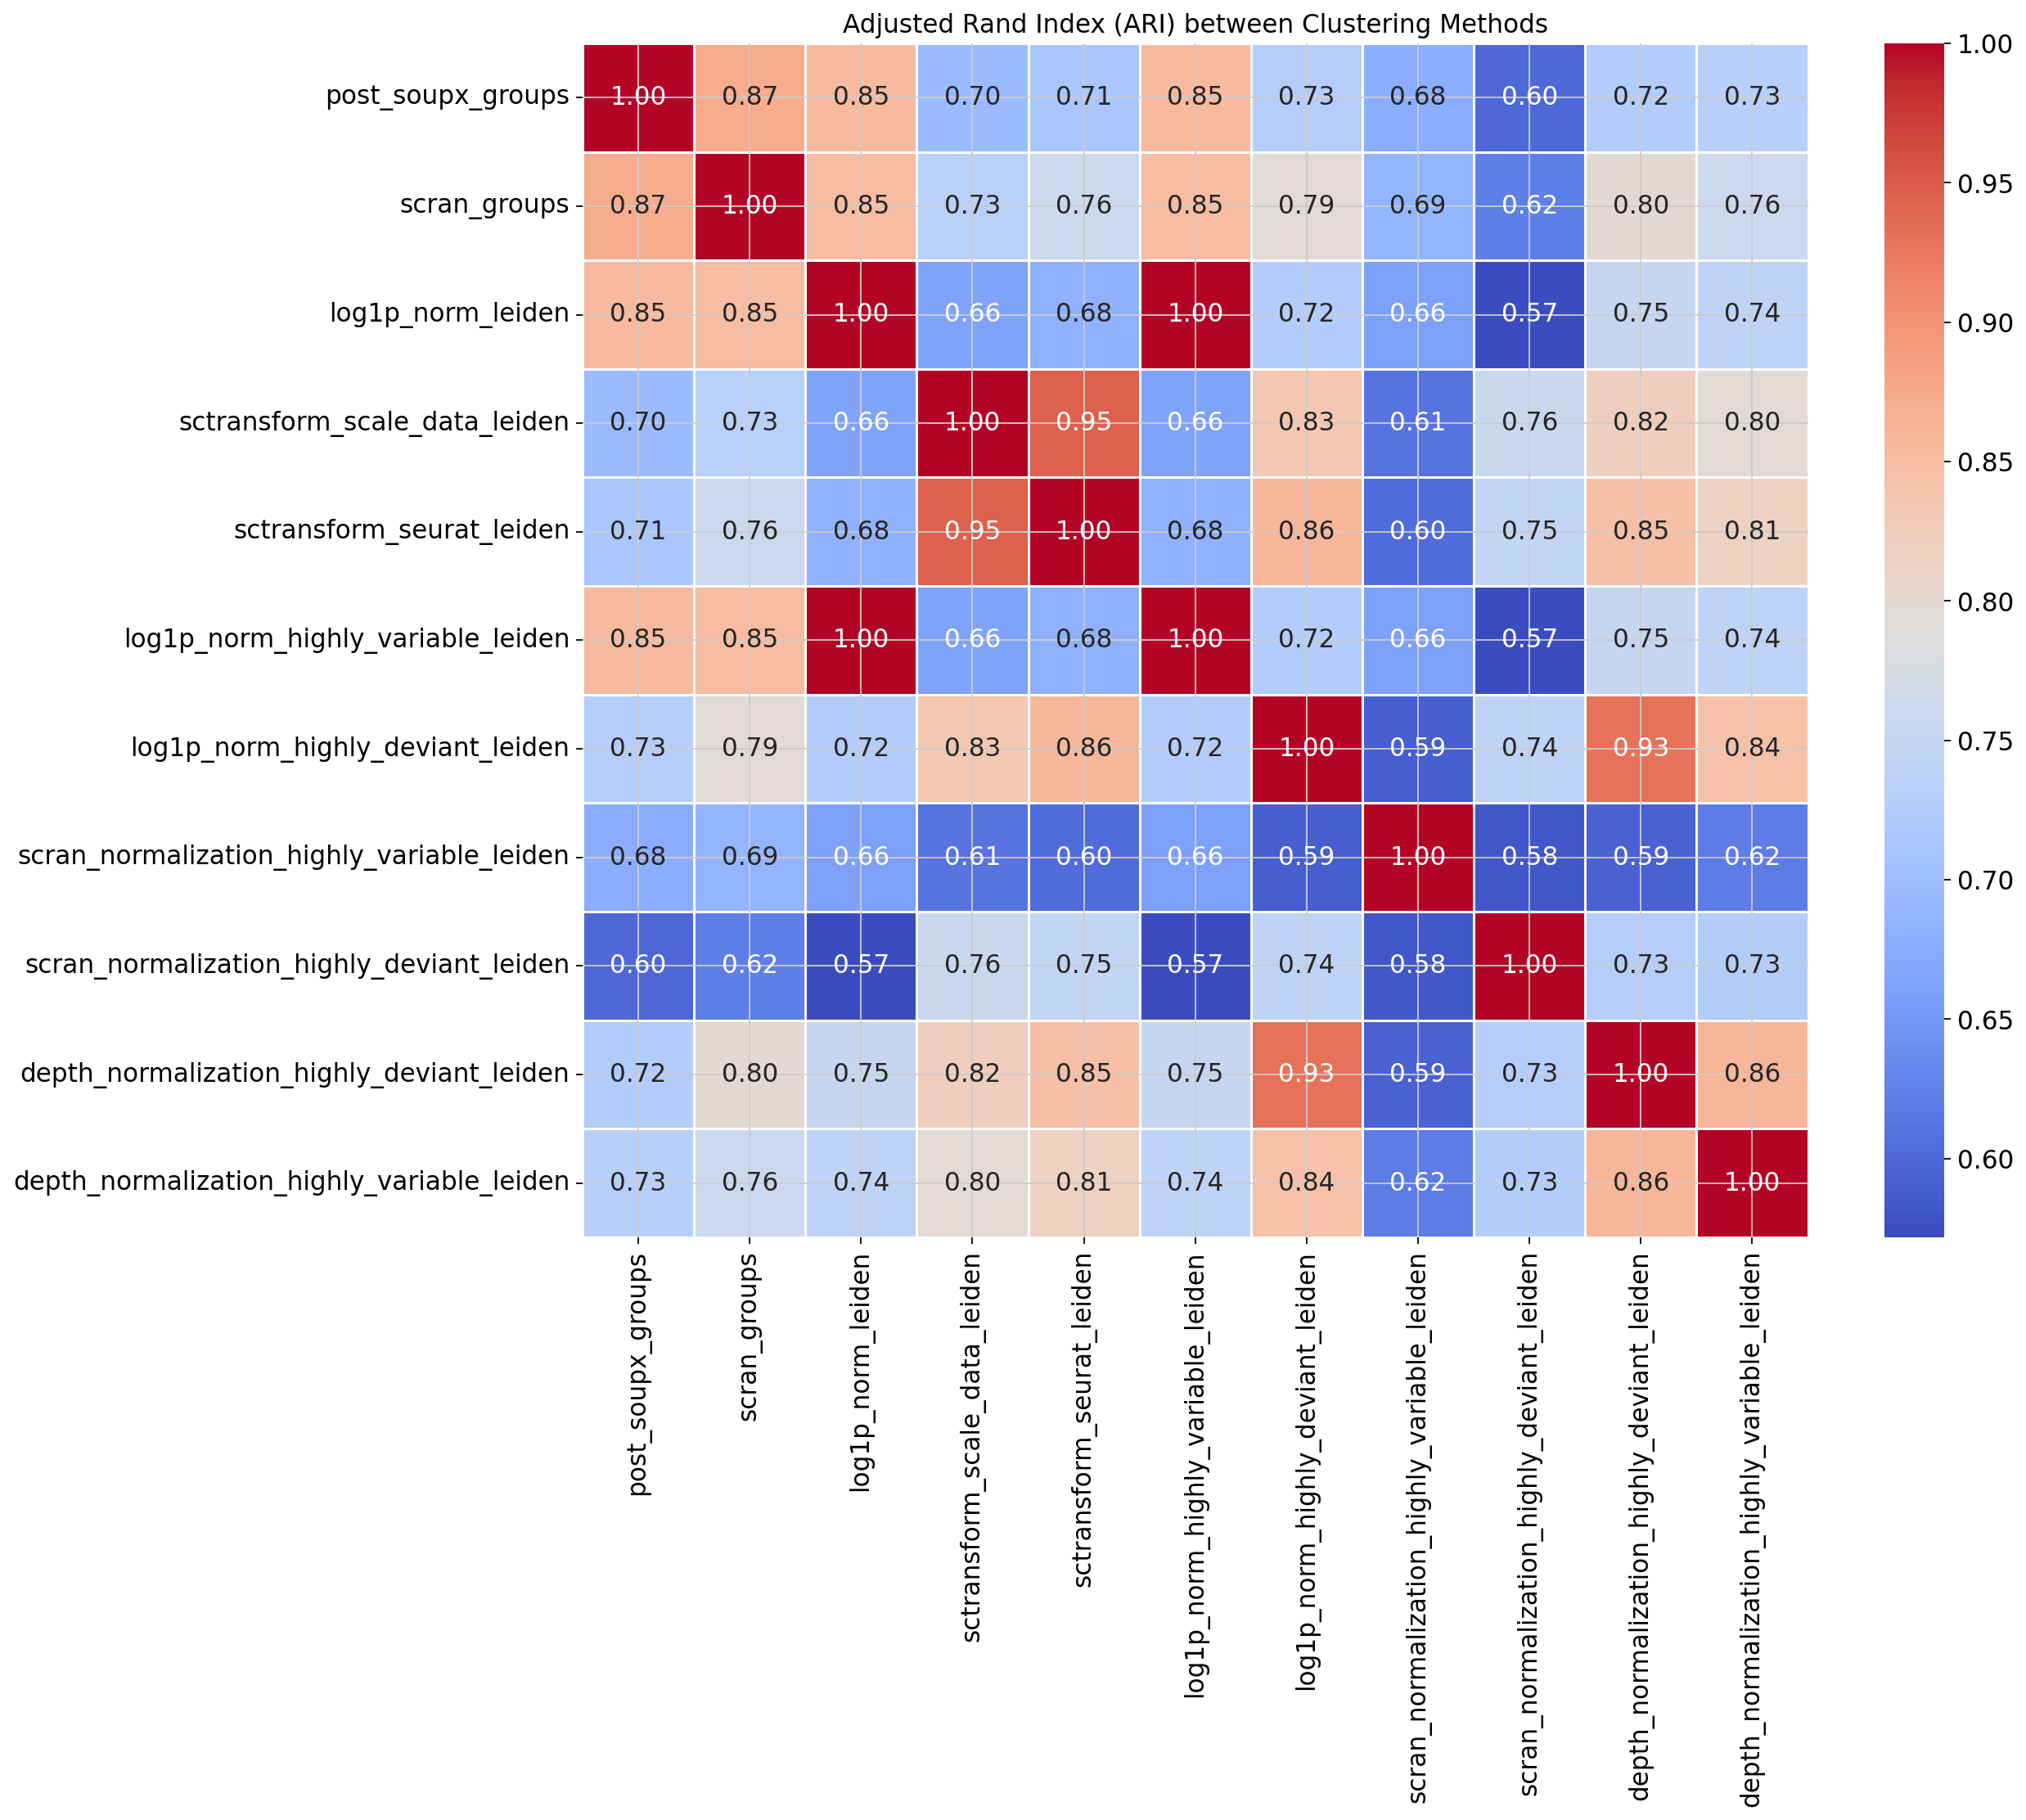

In [92]:
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Remove the first column which contains cell barcodes
data = adata.obs[cluster_cols]
cluster_data = data.drop(data.columns[0], axis=1)

# Number of clustering methods
num_methods = len(cluster_data.columns)

# Initialize an empty matrix to store ARI scores
ari_matrix = np.zeros((num_methods, num_methods))

# Populate the matrix with ARI scores
for i, (column1, data1) in enumerate(cluster_data.iteritems()):
    for j, (column2, data2) in enumerate(cluster_data.iteritems()):
        if i == j:
            ari_matrix[i, j] = 1
        if i < j:
            ari_matrix[i, j] = adjusted_rand_score(data1, data2)
            ari_matrix[j, i] = ari_matrix[i, j]  # the matrix is symmetric
        

# Convert the matrix to a dataframe
ari_df = pd.DataFrame(ari_matrix, index=cluster_data.columns, columns=cluster_data.columns)

# Create a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(ari_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, cbar=True)
plt.title("Adjusted Rand Index (ARI) between Clustering Methods")
plt.show()

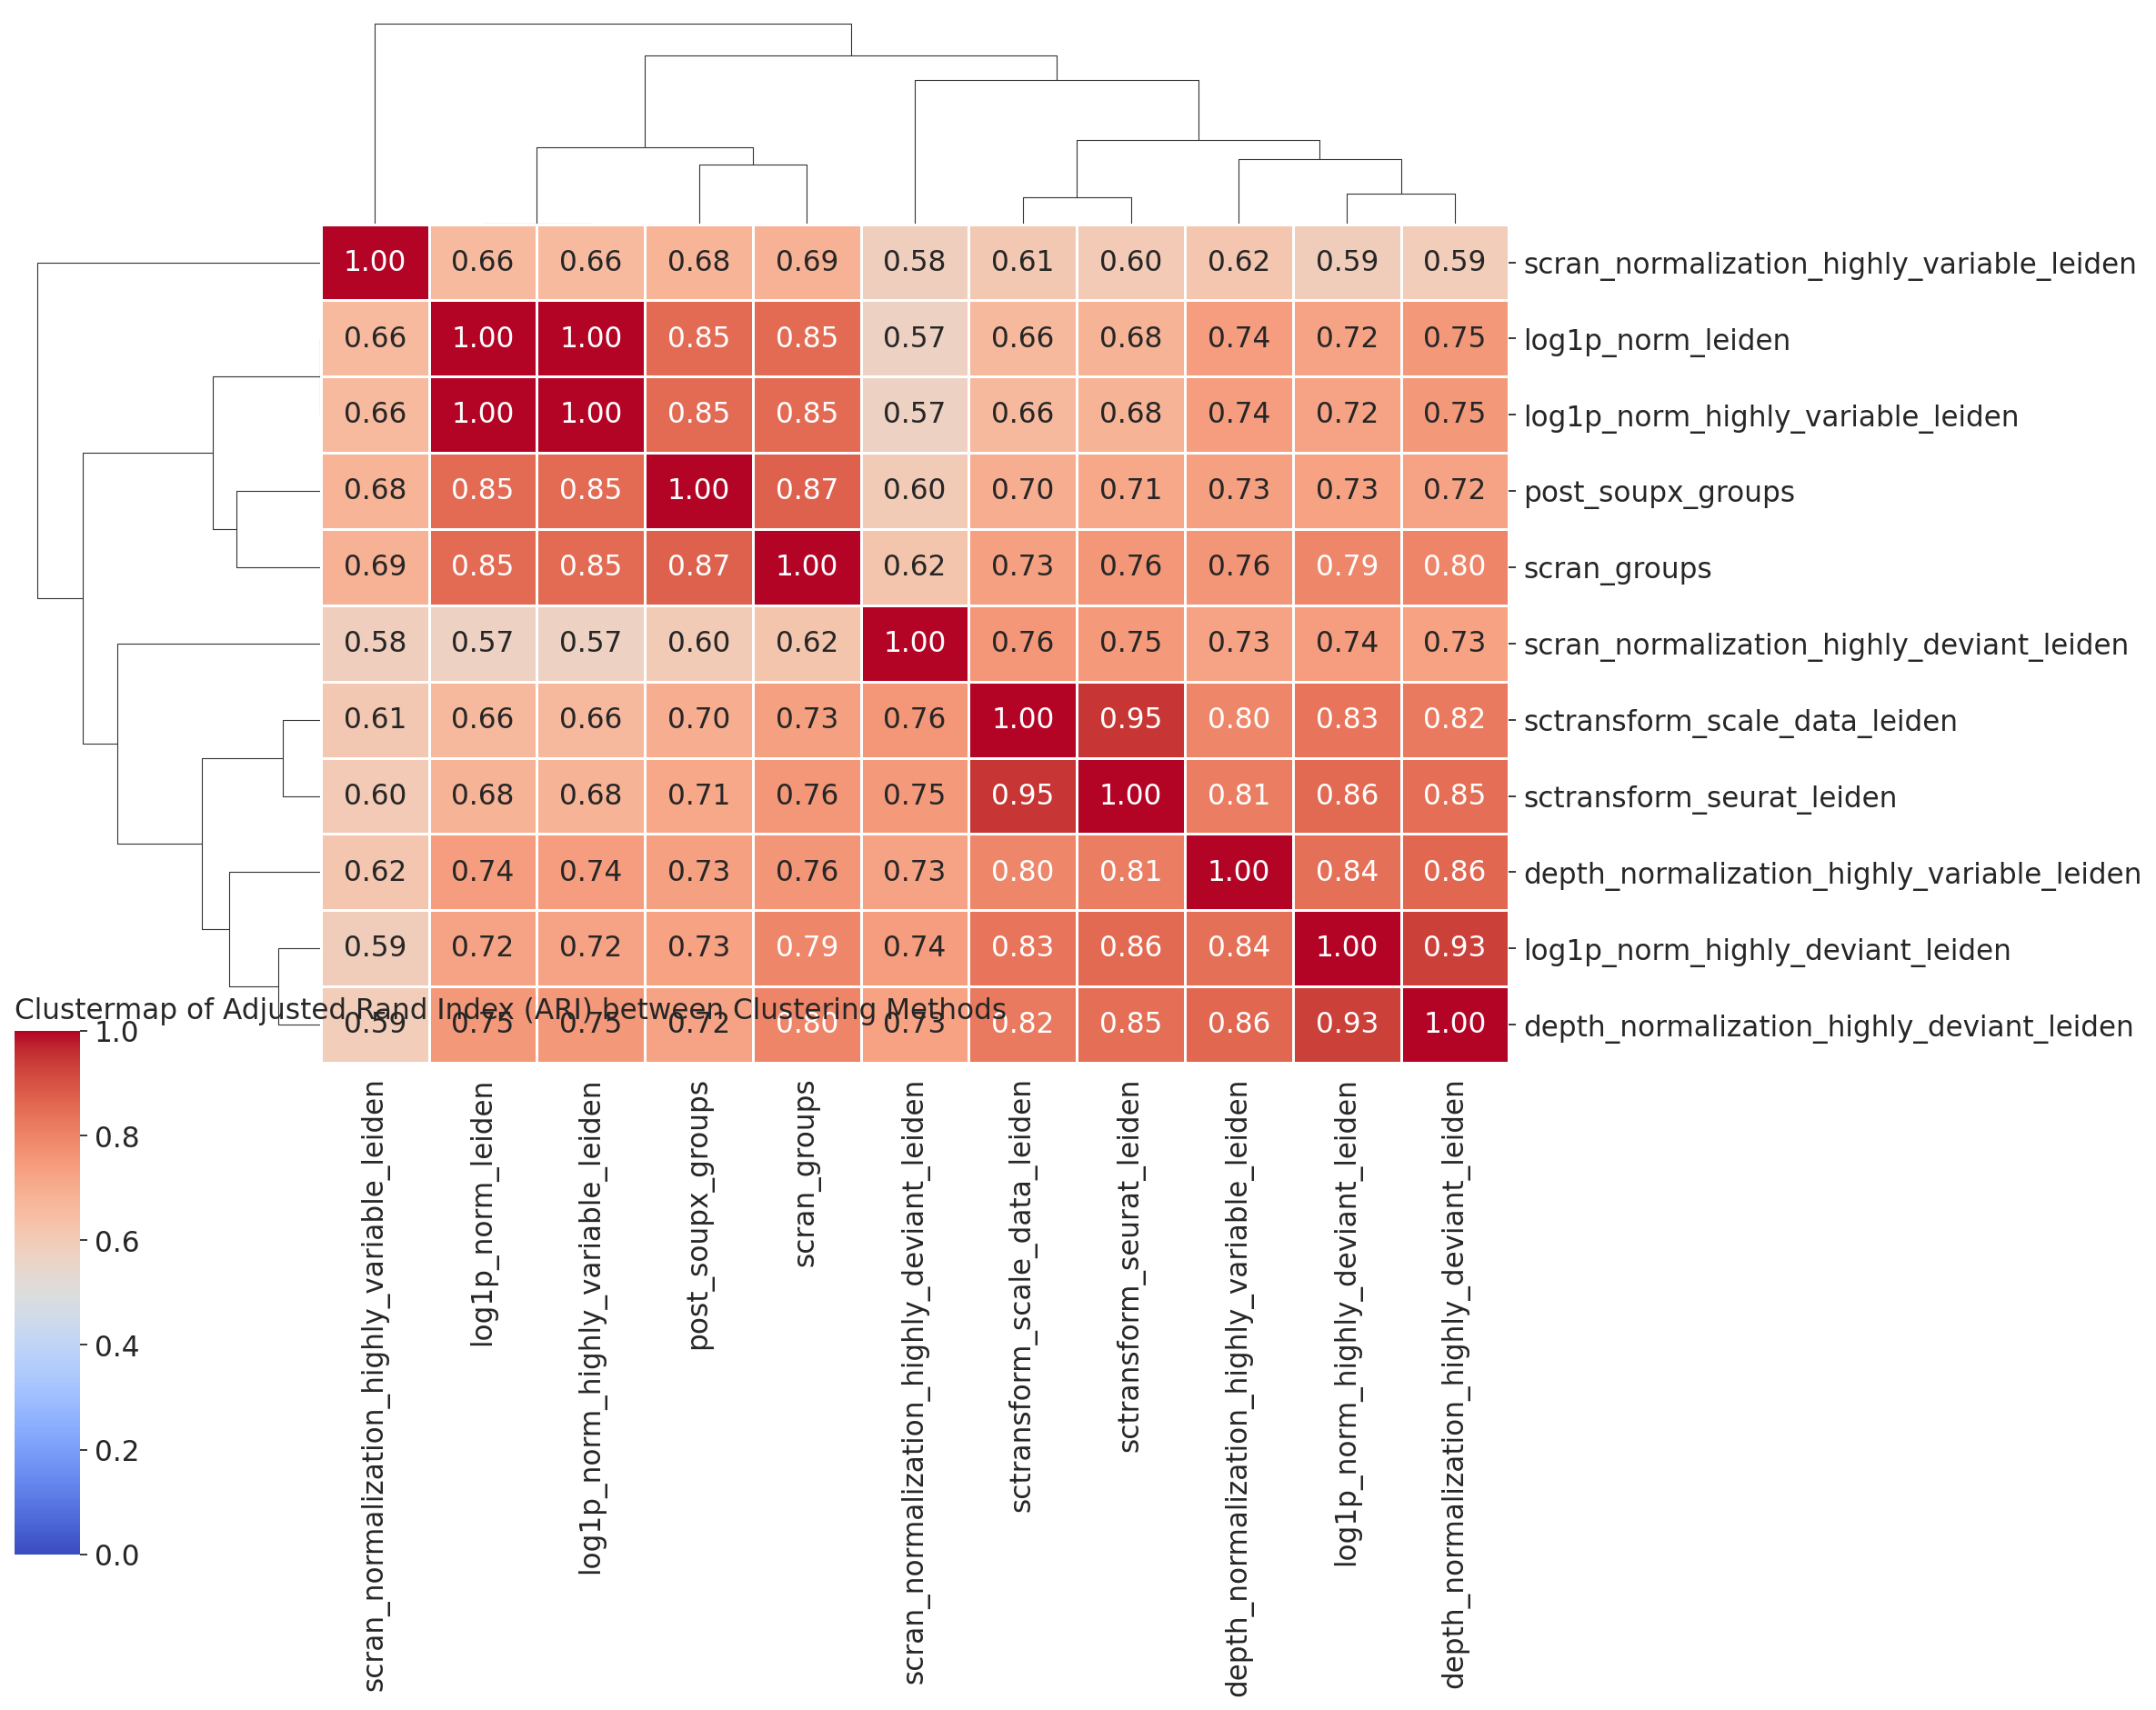

In [95]:
sns.set_style("white")
sns.clustermap(ari_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, figsize=(15, 12), cbar_pos=(0.01, 0.1, 0.03, 0.3), vmin=0, vmax=1)
plt.title("Clustermap of Adjusted Rand Index (ARI) between Clustering Methods", loc='left')
plt.show()